## Clustering for image classification
[readmore](https://rpubs.com/Sharon_1684/454441)

Code are based on [here](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/)

## Setting up

In [2]:
import pandas as pd
import os

from skimage.transform import resize
from skimage.io import imread
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT
from skimage import transform


import skimage

import numpy as np
import matplotlib.pyplot as plt

import joblib
from tqdm import tqdm
from collections import Counter
from PIL import Image 

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import sys
sys.path.insert(1, '../../scripts/')

from svm_functions import resize_all, RGB2GrayTransformer, HogTransformer


from scipy.stats import mode

from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import DBSCAN, MiniBatchKMeans, KMeans, AgglomerativeClustering

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from time import time


%matplotlib inline

In [3]:
repo_name = 'Respiratory_Disease_Classification'
cwd_path = os.getcwd()
train_dir = cwd_path.split(repo_name, 1)[0]+repo_name+"/data/images/90-10_split/train"
src = os.listdir(train_dir)[1:]

## Re-size train and validation images
save the resized image into pkl data for later loading.

In [4]:
base_name_train = 'spectrogram_train'
width = 80
include = src

# resize_all(src=train_dir,pklname=base_name, width=width, include=src)

In [5]:
base_name_val = 'spectrogram_val'
train_dir = cwd_path.split(repo_name, 1)[0]+repo_name+"/data/images/90-10_split/val"

# resize_all(src=train_dir,pklname=base_name_val, width=width, include=src)

In [6]:
base_name_test = 'spectrogram_test'
train_dir = cwd_path.split(repo_name, 1)[0]+repo_name+"/data/images/90-10_split/test"

# resize_all(src=train_dir,pklname=base_name_test, width=width, include=src)

Information on the data exported

In [7]:
data_train = joblib.load(f'{base_name_train}_{width}x{width}px.pkl')
data_val = joblib.load(f'{base_name_val}_{width}x{width}px.pkl')
data_test = joblib.load(f'{base_name_test}_{width}x{width}px.pkl')
 
print('number of training samples: ', len(data_train['data']))
print('number of validation samples: ', len(data_val['data']))
print('number of validation samples: ', len(data_test['data']))

print('keys: ', list(data_train.keys()))
print('description: ', data_train['description'])
print('image shape: ', data_train['data'][0].shape)
print('labels:', np.unique(data_train['label']))
 
print("Training data",Counter(data_train['label']))
print("Validation data", Counter(data_val['label']))
print("Test data", Counter(data_test['label']))

number of training samples:  2491
number of validation samples:  998
number of validation samples:  2072
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)animal images in rgb
image shape:  (80, 80, 3)
labels: ['0' '1']
Training data Counter({'0': 1508, '1': 983})
Validation data Counter({'0': 674, '1': 324})
Test data Counter({'0': 1345, '1': 727})


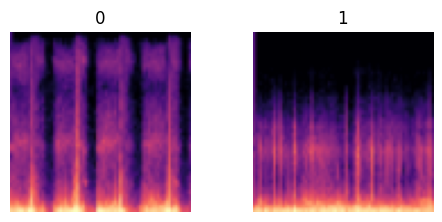

In [8]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data_train['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(5,3)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data_train['label'].index(label)
     
    ax.imshow(data_train['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [17]:
# Define Train-Test, use validation data for testing
X_train = np.array(data_train['data'])
y_train = np.array(data_train['label'])
X_test = np.array(data_val['data'])
y_test = np.array(data_val['label'])


In [21]:
grayify = RGB2GrayTransformer()
X_train_gray = grayify.transform(X_train)
X_train_gray.shape

(2491, 80, 80)

In [28]:
X_train = X_train_gray.reshape(2491,6400)

## Clustering

Simple `KMeans` cluster model

In [27]:
X_train_gray.shape

(2491, 80, 80)

In [33]:
# Creating the KMeans model and predict digits
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X_train)
kmeans.cluster_centers_.shape

(2, 6400)

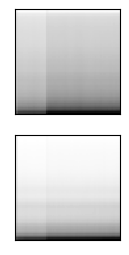

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(2, 80, 80)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [42]:
np.int32(y_train)

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [41]:
clusters

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

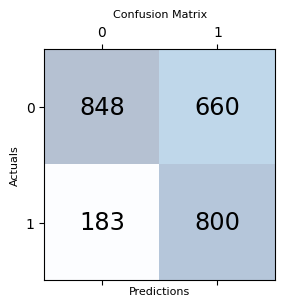

In [43]:
cm_gridS = confusion_matrix(np.int32(y_train), clusters)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm_gridS, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm_gridS.shape[0]):
    for j in range(cm_gridS.shape[1]):
        ax.text(x=j, y=i,s=cm_gridS[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=8)
plt.ylabel('Actuals', fontsize=8)
plt.title('Confusion Matrix', fontsize=8)
plt.show()


In [44]:
print(classification_report(np.int32(y_train), clusters))

              precision    recall  f1-score   support

           0       0.82      0.56      0.67      1508
           1       0.55      0.81      0.65       983

    accuracy                           0.66      2491
   macro avg       0.69      0.69      0.66      2491
weighted avg       0.71      0.66      0.66      2491



## TSNE

In [51]:
# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(X_train)

/Users/liki/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Accuracy:  0.6053793657165797
[[1508    0]
 [ 983    0]]
              precision    recall  f1-score   support

           0       0.61      1.00      0.75      1508
           1       0.00      0.00      0.00       983

    accuracy                           0.61      2491
   macro avg       0.30      0.50      0.38      2491
weighted avg       0.37      0.61      0.46      2491



/Users/liki/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liki/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liki/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

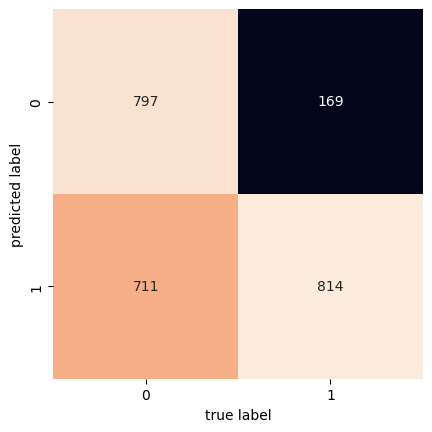

In [53]:
import seaborn as sns
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Plot the confusion matrix
mat = confusion_matrix(np.int32(y_train), clusters)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Compute the accuracy
print('Accuracy: ', accuracy_score(np.int32(y_train), labels))
print('==============================================================')
print(confusion_matrix(np.int32(y_train), labels))
print('==============================================================')
print(classification_report(np.int32(y_train), labels))